In [1]:
!pip install nltk==3.8.1 sentence-transformers
# !pip install pytorch2tikz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=933e3c0472d84f09156ebdb09aa08262c27269a1317f53957eb013de6c7e555c
  Stored in directory: /root/.cache/pip/wheels/83/71/2b/40d17d21937fed496fb99145227eca8f20b4891240ff60c86f
Successfully built sentence-transformers
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Input, Embedding, Dropout, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score


In [3]:
df = pd.read_csv('/kaggle/input/latestones/latest3.csv')

le = LabelEncoder()
cdf = df.copy()
cdf['truth_value'] = le.fit_transform(cdf['truth_value'])

In [4]:
nan_mask = cdf['simple_sentence'].isna()
nan_indices = cdf[nan_mask].index

# Replace NaN values in 'B' with values from column 'A'
cdf.loc[nan_indices, 'simple_sentence'] = df.loc[nan_indices, 'claim']

cdf['simple_sentence'].isna().sum()

0

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
def stemm_text(text):
    return ' '.join([stemmer.stem(w) for w in text.split(' ')])

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in text.split(' ')])

T = cdf['claim'].str.split(' \n\n---\n\n').str[0]
T = T.str.replace('-',' ').str.replace('[^\w\s]','').str.replace('\n',' ').str.lower()
stop = stopwords.words('english')
T = T.apply(lambda x: ' '.join([y for y in x.split() if not y.isdigit()]))
T = T.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
cdf['claim'] = T

T = cdf['simple_sentence'].str.split(' \n\n---\n\n').str[0]
T = T.str.replace('-',' ').str.replace('[^\w\s]','').str.replace('\n',' ').str.lower()
stop = stopwords.words('english')
T = T.apply(lambda x: ' '.join([y for y in x.split() if not y.isdigit()]))
T = T.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
cdf['simple_sentence'] = T
cdf.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: The default value of regex will change from True to False in a future version.


,Unnamed: 0,claim,simple_sentence,truth_value,source
0,0,ukraine theft homicide levels rose due power o...,ukraine theft homicide levels rose due power o...,0,vox-ukraine
1,1,ukrainians beat two berlin residents speaking ...,ukrainians beat two berlin residents speaking ...,0,vox-ukraine
2,2,quote paul goebbels banderites,quote paul goebbels banderites,0,vox-ukraine
3,3,culture good neighborliness course ukrainian s...,culture good neighborliness course ukrainian s...,0,vox-ukraine
4,4,us research ukraine led increase incidence tic...,us research ukraine led increase incidence tic...,0,vox-ukraine
5,5,chile law rights mutants genetically modified ...,chile law rights mutants approved ostap stakhi...,0,vox-ukraine
6,6,covid incidence rate became zero late may,covid incidence rate became zero late may,0,vox-ukraine
7,7,risk death among children vaccinated covid tim...,risk death among children vaccinated covid tim...,0,vox-ukraine
8,8,russias army destroyed,russias army destroyed,0,politifact
9,9,war ukraine,war ukraine,0,politifact


In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
adf = cdf.copy()
grouped = adf.groupby('truth_value')

# Sample 900 rows from each group
sampled = grouped.apply(lambda x: x.sample(n=566))

# Reset the index of the sampled data
sampled = sampled.reset_index(drop=True)
sampled.head(), sampled['truth_value'].value_counts()

(   Unnamed: 0                                              claim  \
 0        9384  rocket attack mall kremenchuk provocation arme...   
 1        8990  ortega denies torture nicaraguas prisons publi...   
 2       11921                 yale shut art history course white   
 3        8548                   lockdown ukraine extended spring   
 4       10908  us eu organised coup détat kyiv creating extre...   
 
                                      simple_sentence  truth_value       source  
 0  rocket attack mall kremenchuk provocation arme...            0     stopfake  
 1  ortega denies torture nicaraguas prisons publi...            0    polygraph  
 2                 yale shut art history course white            0     stopfake  
 3                   lockdown ukraine extended spring            0     stopfake  
 4  us organised coup détat kyiv creating extremel...            0  EUvsDisinfo  ,
 0    566
 1    566
 Name: truth_value, dtype: int64)

In [8]:
cdf = cdf.sample(frac=1).reset_index(drop=True)
X = cdf[['claim', 'simple_sentence']]
y = cdf['truth_value']

# X = X.apply(lambda w: lemmatize_text(w))
X['claim'] = X['claim'].apply(lambda w: lemmatize_text(w))
X['simple_sentence'] = X['simple_sentence'].apply(lambda w: lemmatize_text(w))
X.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,claim,simple_sentence
0,taiwan chinese two millennium let check history,taiwan chinese two millennium let check history
1,london helping kyiv turn country nuclear waste...,london helping kyiv turn country nuclear waste...
2,official rudy giuliani officially resigns trum...,official rudy giuliani officially resigns trum...
3,oleksiy arestovych adviser president zelensky ...,oleksiy arestovych adviser president zelensky ...
4,putin situation ukraine civilized choice,putin situation ukraine civilized choice


In [31]:
!mkdir /root/nltk_data

mkdir: cannot create directory ‘/root/nltk_data’: File exists


In [32]:
nltk.download('wordnet', download_dir='./wordnet')

[nltk_data] Downloading package wordnet to ./wordnet...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
!unzip -o ./wordnet/corpora/wordnet.zip -d /root/nltk_data/corpora/ 

Archive:  ./wordnet/corpora/wordnet.zip
replace /root/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [9]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

In [10]:
def tokenizeAndGenerateSequences(X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    tk1 = text.Tokenizer(num_words=2000)
    tk2 = text.Tokenizer(num_words=2000)
    tk1.fit_on_texts(xtrain['claim'])
    tk2.fit_on_texts(xtrain['simple_sentence'])
    tokenized_train_claim = tk1.texts_to_sequences(xtrain['claim'])
    tokenized_train_ss = tk2.texts_to_sequences(xtrain['simple_sentence'])
    X_train_claim = torch.tensor(sequence.pad_sequences(tokenized_train_claim, maxlen=60)).to(device)
    X_train_ss = torch.tensor(sequence.pad_sequences(tokenized_train_ss, maxlen=60)).to(device)
    tokenized_test_claim = tk1.texts_to_sequences(xtest['claim'])
    tokenized_test_ss = tk1.texts_to_sequences(xtest['simple_sentence'])
    X_test_claim = torch.tensor(sequence.pad_sequences(tokenized_test_claim, maxlen=60)).to(device)
    X_test_ss = torch.tensor(sequence.pad_sequences(tokenized_test_ss, maxlen=60)).to(device)

    # Convert labels to tensors
    y_train = torch.tensor(ytrain.values).float().to(device)
    y_test = torch.tensor(ytest.values).float().to(device)
    
    return X_train_claim, X_train_ss, y_train, X_test_claim, X_test_ss, y_test

# X_train_txt, y_train_txt, X_test_txt, y_test_txt = xtrain, xtest, ytrain, ytest = train_test_split(cdf['claim'], cdf['truth_value'], test_size=0.2, random_state=42)
X_train_claim, X_train_ss, y_train, X_test_claim, X_test_ss, y_test = tokenizeAndGenerateSequences(X, y)

In [12]:

# Define the model architecture
class BiLSTM(nn.Module):
    def __init__(self, num_words, embed_size, hidden_size, fc_out_size, output_size, dropout_rate):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(num_words, embed_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.bilstm1 = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Linear(hidden_size * 2, fc_out_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm1(x)
        x = self.dropout(x)
        x, _ = self.bilstm2(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])
#         x = self.fc(torch.flatten(x, start_dim=1))
        return x
    

# plt.plot([i for i in range(1, 51)], acc)

In [13]:

# Define the model architecture
class BiLSTM2(nn.Module):
    def __init__(self, num_words, embed_size, hidden_size, fc_out_size, output_size, dropout_rate):
        super(BiLSTM2, self).__init__()
        self.embedding = nn.Embedding(num_words, embed_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.bilstm1 = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm1(x)
        x = self.dropout(x)
        x, _ = self.bilstm2(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])
#         x = self.fc(torch.flatten(x, start_dim=1))
        return self.sigmoid(x)
    

# plt.plot([i for i in range(1, 51)], acc)

In [14]:
class TreeBiLSTM(nn.Module):
    def __init__(self, num_words, embed_size, hidden_size, fc_out_size, output_size, dropout_rate):
        super(TreeBiLSTM, self).__init__()
        self.model1 = BiLSTM(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
        self.model2 = BiLSTM(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
        self.fc1 = nn.Linear(fc_out_size * 2, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        a = self.model1(x[0])
        b = self.model2(x[1])
        
        res = torch.cat((a, b), 1)
#         print(a.shape, b.shape, res.shape)
        res = self.fc1(res)
        res = self.fc2(res)
        res = self.fc3(res)
        res = self.sigmoid(res)
        return res      
        
        

In [15]:

# Train the model
te = 50
acc = []
tracc = []
dataset = torch.utils.data.TensorDataset(X_train_claim, y_train)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1024, shuffle=True)
for e in range(te, te+1):
    ctracc = 0
    model = TreeBiLSTM(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    model.train()
    curtraacc = []
    for epoch in range(e):
        optimizer.zero_grad()
        outputs = model([X_train_claim.to(device), X_train_ss.to(device)])
        loss = criterion(outputs.squeeze(), y_train.to(device))
#         losses.append(loss)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            predictions = model([X_train_claim.to(device), X_train_ss.to(device)])
            predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()
        train_accuracy = metrics.accuracy_score(y_train.to(device).to('cpu'), predictions)
        ctracc += train_accuracy
        curtraacc.append(train_accuracy)

    ctracc /= e

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model([X_test_claim.to(device), X_test_ss.to(device)])
        predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()

    print(f"Total Epochs: {e}, Train Accuracy: {ctracc} Test Accuracy: {metrics.accuracy_score(y_test.to('cpu'), predictions)}")
    acc.append(metrics.accuracy_score(y_test.to('cpu'), predictions))
    tracc.append(ctracc)
#     break
#     plt.plot([i for i in range(a)], curtraacc)
    torch.save(model.state_dict(), 'arch1.pt')
# print('Max acc -', max(acc), ' with epochs -', acc.index(max(acc)))

Total Epochs: 50, Train Accuracy: 0.6848937273198545 Test Accuracy: 0.4701492537313433


In [168]:
X_train_claim.shape

torch.Size([9645, 60])

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


model.eval()
with torch.no_grad():
    predictions = model([X_test_claim.to(device), X_test_ss.to(device)])
    predictions = (predictions > 0.95).to('cpu').int().squeeze().numpy()
    Y_TEST = y_test.to('cpu')
    
    
    print(classification_report(Y_TEST, predictions))
    print(confusion_matrix(Y_TEST, predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1278
         1.0       0.47      1.00      0.64      1134

    accuracy                           0.47      2412
   macro avg       0.24      0.50      0.32      2412
weighted avg       0.22      0.47      0.30      2412

[[   0 1278]
 [   0 1134]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:

# Train the model
te = 25
acc = []
tracc = []
dataset = torch.utils.data.TensorDataset(X_train_ss, y_train)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1024, shuffle=True)
curtraacc = []
model1 = None
for e in range(te, te+1):
    ctracc = 0
    model1 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
    model1.train()
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model1.parameters(), lr=0.01)

    model1.train()
    for epoch in range(e):
        optimizer.zero_grad()
        outputs = model1(X_train_claim.to(device))
        loss = criterion(outputs.squeeze(), y_train.to(device))
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            predictions = model1(X_train_claim.to(device))
            predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()
        train_accuracy = metrics.accuracy_score(y_train.to(device).to('cpu'), predictions)
        ctracc += train_accuracy
        curtraacc.append(train_accuracy)

    ctracc /= e

    # Evaluate the model
    model1.eval()
    with torch.no_grad():
        predictions = model1(X_test_ss)
        predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()

    print(f"Total Epochs: {e}, Train Accuracy: {ctracc} Test Accuracy: {metrics.accuracy_score(y_test.to('cpu'), predictions)}")
    acc.append(metrics.accuracy_score(y_test.to('cpu'), predictions))
    tracc.append(ctracc)
#     plt.plot([i for i in range(te)], curtraacc)
#     break
print('Max acc -', max(acc), ' with epochs -', acc.index(max(acc)))

Total Epochs: 25, Train Accuracy: 0.8511850699844479 Test Accuracy: 0.8598673300165838
Max acc - 0.8598673300165838  with epochs - 0


In [18]:

# Train the model
te = 25
acc = []
tracc = []
dataset = torch.utils.data.TensorDataset(X_train_ss, y_train)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1024, shuffle=True)
curtraacc = []
model2 = None
for e in range(te, te+1):
    ctracc = 0
    model2 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
    model2.train()
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model2.parameters(), lr=0.01)

    model2.train()
    for epoch in range(e):
        optimizer.zero_grad()
        outputs = model2(X_train_ss.to(device))
        loss = criterion(outputs.squeeze(), y_train.to(device))
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            predictions = model2(X_train_ss.to(device))
            predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()
        train_accuracy = metrics.accuracy_score(y_train.to(device).to('cpu'), predictions)
        ctracc += train_accuracy
        curtraacc.append(train_accuracy)

    ctracc /= e

    # Evaluate the model
    model2.eval()
    with torch.no_grad():
        predictions = model2(X_test_ss)
        predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()

    print(f"Total Epochs: {e}, Train Accuracy: {ctracc} Test Accuracy: {metrics.accuracy_score(y_test.to('cpu'), predictions)}")
    acc.append(metrics.accuracy_score(y_test.to('cpu'), predictions))
    tracc.append(ctracc)
#     plt.plot([i for i in range(te)], curtraacc)
#     break
print('Max acc -', max(acc), ' with epochs -', acc.index(max(acc)))

Total Epochs: 25, Train Accuracy: 0.8559709694142044 Test Accuracy: 0.7023217247097844
Max acc - 0.7023217247097844  with epochs - 0


In [19]:
torch.save(model1.state_dict(), '/kaggle/working/raw.pt')
torch.save(model2.state_dict(), '/kaggle/working/ss.pt')

In [47]:
ytf = []
yyyyy = y_test.detach().cpu().numpy()
xtct = []
for i in range(len(yyyyy)):
#     if yyyyy[i] == 0:
    ytf.append(yyyyy[i])
    xtct.append(X_test_claim[i].detach().cpu().numpy())

In [48]:
from sklearn.metrics import classification_report


model1.eval()
with torch.no_grad():
    predictions = model1(torch.tensor(np.array(xtct)).to(device))
    predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()
    Y_TEST = torch.tensor(np.array(ytf))
    

    print(classification_report(Y_TEST, predictions))
    print(confusion_matrix(Y_TEST, predictions))
    

model2.eval()
with torch.no_grad():
    predictions = model2(torch.tensor(np.array(xtct)).to(device))
    predictions = (predictions > 0.5).to('cpu').int().squeeze().numpy()
    Y_TEST = torch.tensor(np.array(ytf))
    

    print(classification_report(Y_TEST, predictions))
    print(confusion_matrix(Y_TEST, predictions))

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87      1278
         1.0       0.86      0.85      0.85      1134

    accuracy                           0.86      2412
   macro avg       0.86      0.86      0.86      2412
weighted avg       0.86      0.86      0.86      2412

[[1125  153]
 [ 174  960]]
              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72      1278
         1.0       0.69      0.69      0.69      1134

    accuracy                           0.71      2412
   macro avg       0.70      0.70      0.70      2412
weighted avg       0.71      0.71      0.71      2412

[[919 359]
 [352 782]]


In [ ]:
!pip show tensorflow

In [ ]:
torch.save(model.state_dict(), 'rs.pt')

In [49]:
def tokenizeAndGenerateSequences(X, y):
    tk1 = text.Tokenizer(num_words=2000)
    tk2 = text.Tokenizer(num_words=2000)
    tk1.fit_on_texts(X['claim'])
    tk2.fit_on_texts(X['simple_sentence'])
    tokenized_train_claim = tk1.texts_to_sequences(X['claim'])
    tokenized_train_ss = tk2.texts_to_sequences(X['simple_sentence'])
    X = torch.tensor(sequence.pad_sequences(tokenized_train_claim, maxlen=60)).to(device)
    X = torch.tensor(sequence.pad_sequences(tokenized_train_ss, maxlen=60)).to(device)

    # Convert labels to tensors
    y = torch.tensor(y.values).float().to(device)
    
    return X, y

# X_train_txt, y_train_txt, X_test_txt, y_test_txt = xtrain, xtest, ytrain, ytest = train_test_split(cdf['claim'], cdf['truth_value'], test_size=0.2, random_state=42)
nx, ny = tokenizeAndGenerateSequences(X, y)

In [177]:
m1 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
m2 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
s1 = torch.load('/kaggle/working/raw.pt')
s2 = torch.load('/kaggle/working/ss.pt')
m1.load_state_dict(s1)
m2.load_state_dict(s2)

<All keys matched successfully>

In [178]:
from sklearn.metrics import classification_report, confusion_matrix

svmx = []
svmy = []

ytr = []
cury = y_train.detach().cpu().numpy()
xtr1 = []
xtr2 = []
for i in range(len(cury)):
#     if yyyyy[i] == 0:
    ytr.append(cury[i])
    xtr1.append(X_train_claim[i].detach().cpu().numpy())
    xtr2.append(X_train_ss[i].detach().cpu().numpy())
#     svmx.append(X_train_ss[i].detach().cpu().numpy().tolist())
    
m1.eval()
m2.eval()
with torch.no_grad():
    p1 = m1(torch.tensor(np.array(xtr1)).to(device))
    p1 = (p1 > 0.5).to('cpu').int().squeeze().numpy().tolist()
    p2 = m2(torch.tensor(np.array(xtr2)).to(device))
    p2 = (p2 > 0.5).to('cpu').int().squeeze().numpy().tolist()
#     aaa = X_train_ss[i].detach().cpu().numpy().tolist().copy()
    svmx = [X_train_claim[i].detach().cpu().numpy().tolist() + [p1[i], p2[i]] for i in range(len(p1))]
    
    Y_TRAIN = torch.tensor(np.array(ytr))
    

    print(classification_report(Y_TRAIN, p1))
    print(confusion_matrix(Y_TRAIN, p1))
    print(classification_report(Y_TRAIN, p2))
    print(confusion_matrix(Y_TRAIN, p2))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      5041
         1.0       0.94      0.92      0.93      4604

    accuracy                           0.93      9645
   macro avg       0.94      0.93      0.93      9645
weighted avg       0.94      0.93      0.93      9645

[[4775  266]
 [ 361 4243]]
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      5041
         1.0       0.94      0.93      0.94      4604

    accuracy                           0.94      9645
   macro avg       0.94      0.94      0.94      9645
weighted avg       0.94      0.94      0.94      9645

[[4768  273]
 [ 303 4301]]


In [179]:
from sklearn.metrics import classification_report, confusion_matrix

svmx = []
svmy = []

ytr = []
cury = y_test.detach().cpu().numpy()
xtr1 = []
xtr2 = []
for i in range(len(cury)):
#     if yyyyy[i] == 0:
    ytr.append(cury[i])
    xtr1.append(X_test_claim[i].detach().cpu().numpy())
    xtr2.append(X_test_ss[i].detach().cpu().numpy())
#     svmx.append(X_train_ss[i].detach().cpu().numpy().tolist())
    
m1.eval()
m2.eval()
with torch.no_grad():
    p1 = m1(torch.tensor(np.array(xtr1)).to(device))
    p1 = (p1 > 0.5).to('cpu').int().squeeze().numpy().tolist()
    p2 = m2(torch.tensor(np.array(xtr2)).to(device))
    p2 = (p2 > 0.5).to('cpu').int().squeeze().numpy().tolist()
#     aaa = X_train_ss[i].detach().cpu().numpy().tolist().copy()
    svmx = [X_test_claim[i].detach().cpu().numpy().tolist() + [p1[i], p2[i]] for i in range(len(p1))]
    
    Y_TEST = torch.tensor(np.array(ytr))
    

    print(classification_report(Y_TEST, p1))
    print(confusion_matrix(Y_TEST, p1))
    print(classification_report(Y_TEST, p2))
    print(confusion_matrix(Y_TEST, p2))

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87      1278
         1.0       0.86      0.85      0.85      1134

    accuracy                           0.86      2412
   macro avg       0.86      0.86      0.86      2412
weighted avg       0.86      0.86      0.86      2412

[[1125  153]
 [ 174  960]]
              precision    recall  f1-score   support

         0.0       0.73      0.69      0.71      1278
         1.0       0.67      0.72      0.69      1134

    accuracy                           0.70      2412
   macro avg       0.70      0.70      0.70      2412
weighted avg       0.70      0.70      0.70      2412

[[877 401]
 [317 817]]


In [58]:
from sklearn import svm

clf = svm.SVC(probability=True)
clf.fit(svmx, ytr)
preds = clf.predict(svmx)

print(classification_report(ytr, preds))
print(confusion_matrix(ytr, preds))

SVC(probability=True)

In [ ]:
import pickle

with open('svm.pkl', 'wb') as f:
    pickle.dump(clf, f)

# All below cells are results of various ensembling strats and baselines


In [66]:
m1 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
m2 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
s1 = torch.load('/kaggle/working/raw.pt')
s2 = torch.load('/kaggle/working/ss.pt')
m1.load_state_dict(s1)
m2.load_state_dict(s2)

<All keys matched successfully>

In [92]:
from sklearn.metrics import classification_report, confusion_matrix

svmx_train = []
svmy_train = []
svmx_test = []
svmy_test = []

ytr = []
cury = y_train.detach().cpu().numpy()
xtr1 = []
xtr2 = []
yte = []
curyte = y_test.detach().cpu().numpy()
xte1 = []
xte2 = []
for i in range(len(cury)):
    ytr.append(cury[i])
    xtr1.append(X_train_claim[i].detach().cpu().numpy())
    xtr2.append(X_train_ss[i].detach().cpu().numpy())
for i in range(len(curyte)):
    yte.append(curyte[i])
    xte1.append(X_test_claim[i].detach().cpu().numpy())
    xte2.append(X_test_ss[i].detach().cpu().numpy())


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

m1.bilstm2.register_forward_hook(get_activation('bilstm2_m1'))
m1.eval()
m2.bilstm2.register_forward_hook(get_activation('bilstm2_m2'))
m2.eval()
with torch.no_grad():
    weighted_avg = (torch.tensor(0.8) * activation['bilstm2_m1'][0][:, -1, :].detach().cpu()) + (torch.tensor(0.2) * activation['bilstm2_m2'][0][:, -1, :].detach().cpu())
    svmx_train = weighted_avg.numpy().tolist()
    svmy_train = ytr
    
    weighted_avg = (torch.tensor(0.8) * activation['bilstm2_m1'][0][:, -1, :].detach().cpu()) + (torch.tensor(0.2) * activation['bilstm2_m2'][0][:, -1, :].detach().cpu())
    svmx_test = weighted_avg.numpy().tolist()
    svmy_test = yte
    

clf = svm.SVC(probability=True, kernel='poly')
clf.fit(svmx_train, svmy_train)
preds = clf.predict(svmx_train)
print(classification_report(svmy_train, preds))
print(confusion_matrix(svmy_train, preds))


preds = clf.predict(svmx_test)
print(classification_report(svmy_test, preds))
print(confusion_matrix(svmy_test, preds))

torch.Size([9645, 128])
torch.Size([2412, 128])
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      5041
         1.0       0.97      0.90      0.94      4604

    accuracy                           0.94      9645
   macro avg       0.94      0.94      0.94      9645
weighted avg       0.94      0.94      0.94      9645

[[4915  126]
 [ 446 4158]]
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      1278
         1.0       0.89      0.82      0.85      1134

    accuracy                           0.87      2412
   macro avg       0.87      0.87      0.87      2412
weighted avg       0.87      0.87      0.87      2412

[[1168  110]
 [ 208  926]]


# SVM
            precision    recall  f1-score   support

         0.0       0.78      0.87      0.82      5041
         1.0       0.84      0.72      0.78      4604

    accuracy                           0.80      9645
    macro avg       0.81      0.80      0.80      9645
    weighted avg       0.80      0.80      0.80      9645

[[4388  653]
 [1272 3332]]
              
              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82      1278
         1.0       0.83      0.71      0.77      1134

    accuracy                           0.80      2412
    macro avg       0.80      0.79      0.79      2412
    weighted avg       0.80      0.80      0.79      2412

[[1113  165]
 [ 328  806]]
 
# Best BiLSTM
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      5041
         1.0       0.94      0.92      0.93      4604

    accuracy                           0.93      9645
    macro avg       0.94      0.93      0.93      9645
    weighted avg       0.94      0.93      0.93      9645

[[4775  266]
 [ 361 4243]]
              
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87      1278
         1.0       0.86      0.85      0.85      1134

    accuracy                           0.86      2412
    macro avg       0.86      0.86      0.86      2412
    weighted avg       0.86      0.86      0.86      2412

[[1125  153]
 [ 174  960]]

## Dense layer to calculate the weights in weighted average

In [153]:
!pip install hummingbird-ml

  Using cached hummingbird_ml-0.4.4-py2.py3-none-any.whl (181 kB)
  Using cached onnxconverter_common-1.13.0-py2.py3-none-any.whl (83 kB)


In [93]:
m1 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
m2 = BiLSTM2(num_words=2000, embed_size=60, hidden_size=64, fc_out_size=5000, output_size=1, dropout_rate=0.2).to(device)
s1 = torch.load('/kaggle/working/raw.pt')
s2 = torch.load('/kaggle/working/ss.pt')
m1.load_state_dict(s1)
m2.load_state_dict(s2)

<All keys matched successfully>

In [117]:
a = torch.rand((1), requires_grad=True)
b = torch.rand((1), requires_grad=True)
c = nn.MSELoss()
loss = c(a, b)
loss, a, b

(tensor(0.0007, grad_fn=<MseLossBackward0>),
 tensor([0.3155], requires_grad=True),
 tensor([0.3427], requires_grad=True))

In [167]:
from sklearn.metrics import classification_report, confusion_matrix
from hummingbird.ml import convert, load

class AccuracyLoss(nn.Module):
    def __init__(self):
        super(AccuracyLoss, self).__init__()

    def forward(self, y_true, y_preds):
        loes = torch.sum(y_true == y_preds) / torch.tensor(len(y_preds)).to(device)
        return loss

w1 = torch.rand((1)).to(device)
w2 = torch.rand((1)).to(device)
# weighter_model = Weighter(2, 1)
criterion = AccuracyLoss()
optimizer = optim.SGD([w1, w2], lr=0.01)

ytr = []
cury = y_train.detach().cpu().numpy()
xtr1 = []
xtr2 = []
yte = []
curyte = y_test.detach().cpu().numpy()
xte1 = []
xte2 = []
for i in range(len(cury)):
    ytr.append(cury[i])
    xtr1.append(X_train_claim[i].detach().cpu().numpy())
    xtr2.append(X_train_ss[i].detach().cpu().numpy())
for i in range(len(curyte)):
    yte.append(curyte[i])
    xte1.append(X_test_claim[i].detach().cpu().numpy())
    xte2.append(X_test_ss[i].detach().cpu().numpy())


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

m1.bilstm2.register_forward_hook(get_activation('bilstm2_m1'))
m1.eval()
m2.bilstm2.register_forward_hook(get_activation('bilstm2_m2'))
m2.eval()
wepochs = 3


def compute_xy():
    p1 = m1(torch.tensor(np.array(xtr1)).to(device))
    p1 = (p1 > 0.5).to('cpu').int().squeeze().numpy().tolist()
    p2 = m2(torch.tensor(np.array(xtr2)).to(device))
    p2 = (p2 > 0.5).to('cpu').int().squeeze().numpy().tolist()
    weighted_avg = (w1 * activation['bilstm2_m1'][0][:, -1, :].clone().detach()) + (w2 * activation['bilstm2_m2'][0][:, -1, :].clone().detach())
    svmx_train = weighted_avg
    svmy_train = ytr

    p1 = m1(torch.tensor(np.array(xte1)).to(device))
    p1 = (p1 > 0.5).to('cpu').int().squeeze().numpy().tolist()
    p2 = m2(torch.tensor(np.array(xte2)).to(device))
    p2 = (p2 > 0.5).to('cpu').int().squeeze().numpy().tolist()
    weighted_avg = (w1 * activation['bilstm2_m1'][0][:, -1, :].clone().detach()) + (w2* activation['bilstm2_m2'][0][:, -1, :].clone().detach())
    svmx_test = weighted_avg
    svmy_test = yte
    return svmx_train, torch.tensor(svmy_train).to(device), svmx_test, torch.tensor(svmy_test).to(device)


# with torch.no_grad():
for epoch in range(wepochs):
    optimizer.zero_grad()
    
    svmx_train, svmy_train, svmx_test, svmy_test = compute_xy()
    
    clf = svm.SVC(probability=True, kernel='poly')
    clf.fit(svmx_train.clone().detach().cpu().numpy(), svmy_train.cpu().numpy())
    preds = torch.tensor(clf.predict(svmx_train.clone().detach().cpu().numpy())).to(device)
    wloss = criterion(svmy_train, preds)
    wloss.backward()
    print(wloss)
    optimizer.step()
    print(w1, w2)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

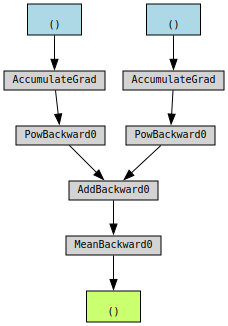

In [163]:
from torchviz import make_dot

make_dot(wloss, params={'w1': w1, 'w2': w2})

In [ ]:
import torch
import torch.optim as optim

# define initial values of a and b
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

# define your loss function that takes a and b as input and returns a scalar value
def loss_function(a, b):
    loss = (a**2 + b**2).mean()  # example loss function, replace with your own
    print(loss)
    return loss

# create an optimizer and set its learning rate
optimizer = optim.SGD([a, b], lr=0.1)  # stochastic gradient descent optimizer

# training loop
num_epochs = 100
for epoch in range(num_epochs):
    # compute the loss value
    loss = loss_function(a, b)
    
    # compute gradients of the loss with respect to a and b
    loss.backward()
    
    # update the values of a and b using the optimizer
    optimizer.step()
    
    # zero the gradients of a and b for the next iteration
    optimizer.zero_grad()
    
    # print the loss value every 100 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()},", a.item(), b.item())

# print the final values of a and b
print(f"Final values of a and b: {a.item()}, {b.item()}")


# Baselines

In [170]:
baseline_x_train = X_train_claim.detach().cpu().numpy().tolist()
baseline_y_train = y_train.detach().cpu().numpy().tolist()
baseline_x_test = X_test_claim.detach().cpu().numpy().tolist()
baseline_y_test = y_test.detach().cpu().numpy().tolist()

In [172]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text

#Logistic Regression with TF-IDF
clf = LogisticRegression(C=1.0)
clf.fit(baseline_x_train, baseline_y_train)
# predictions = clf.predict_proba(baseline_x_test)
predictions = clf.predict(baseline_x_train)
# predictions = [np.argmax(predictions[i]) for i in range(len(predictions))]
print(classification_report(baseline_y_train, predictions))
print(confusion_matrix(baseline_y_train, predictions))

predictions = clf.predict(baseline_x_test)
print(classification_report(baseline_y_test, predictions))
print(confusion_matrix(baseline_y_test, predictions))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      5041
         1.0       0.82      0.70      0.76      4604

    accuracy                           0.78      9645
   macro avg       0.79      0.78      0.78      9645
weighted avg       0.79      0.78      0.78      9645

[[4335  706]
 [1382 3222]]
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80      1278
         1.0       0.81      0.68      0.74      1134

    accuracy                           0.77      2412
   macro avg       0.78      0.77      0.77      2412
weighted avg       0.78      0.77      0.77      2412

[[1101  177]
 [ 368  766]]


In [173]:
#Naive Bayes
clf = MultinomialNB()
clf.fit(baseline_x_train, baseline_y_train)
predictions = clf.predict(baseline_x_train)
# predictions = [np.argmax(predictions[i]) for i in range(len(predictions))]
print(classification_report(baseline_y_train, predictions))
print(confusion_matrix(baseline_y_train, predictions))

predictions = clf.predict(baseline_x_test)
print(classification_report(baseline_y_test, predictions))
print(confusion_matrix(baseline_y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.72      0.92      0.81      5041
         1.0       0.88      0.61      0.72      4604

    accuracy                           0.77      9645
   macro avg       0.80      0.76      0.76      9645
weighted avg       0.79      0.77      0.76      9645

[[4646  395]
 [1816 2788]]
              precision    recall  f1-score   support

         0.0       0.71      0.92      0.80      1278
         1.0       0.87      0.58      0.70      1134

    accuracy                           0.76      2412
   macro avg       0.79      0.75      0.75      2412
weighted avg       0.79      0.76      0.75      2412

[[1180   98]
 [ 474  660]]


In [174]:
#XG-Boost classifier
clf = xgb.XGBClassifier(max_depth=3, n_estimators=50, colsample_bytree=0.8, subsample=0.8, nthread=10, learning_rate=0.01)

clf.fit(baseline_x_train, baseline_y_train)
predictions = clf.predict(baseline_x_train)
# predictions = [np.argmax(predictions[i]) for i in range(len(predictions))]
print(classification_report(baseline_y_train, predictions))
print(confusion_matrix(baseline_y_train, predictions))

predictions = clf.predict(baseline_x_test)
print(classification_report(baseline_y_test, predictions))
print(confusion_matrix(baseline_y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83      5041
         1.0       0.84      0.74      0.79      4604

    accuracy                           0.81      9645
   macro avg       0.81      0.81      0.81      9645
weighted avg       0.81      0.81      0.81      9645

[[4401  640]
 [1199 3405]]
              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82      1278
         1.0       0.84      0.72      0.78      1134

    accuracy                           0.80      2412
   macro avg       0.81      0.80      0.80      2412
weighted avg       0.81      0.80      0.80      2412

[[1117  161]
 [ 313  821]]


In [176]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(baseline_x_train, baseline_y_train)
predictions = clf.predict(baseline_x_train)
# predictions = [np.argmax(predictions[i]) for i in range(len(predictions))]
print(classification_report(baseline_y_train, predictions))
print(confusion_matrix(baseline_y_train, predictions))

predictions = clf.predict(baseline_x_test)
print(classification_report(baseline_y_test, predictions))
print(confusion_matrix(baseline_y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      5041
         1.0       0.86      0.67      0.75      4604

    accuracy                           0.79      9645
   macro avg       0.80      0.78      0.78      9645
weighted avg       0.80      0.79      0.79      9645

[[4521  520]
 [1512 3092]]
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      1278
         1.0       0.86      0.66      0.75      1134

    accuracy                           0.79      2412
   macro avg       0.80      0.78      0.78      2412
weighted avg       0.80      0.79      0.79      2412

[[1151  127]
 [ 380  754]]


In [84]:
clf = SVC(probability=True)
clf.fit(baseline_x_train, baseline_y_train)
predictions = clf.predict_proba(baseline_x_train)
predictions = [np.argmax(predictions[i]) for i in range(len(predictions))]
print(classification_report(baseline_y_train, predictions))
print(confusion_matrix(baseline_y_train, predictions))
predictions = clf.predict_proba(baseline_x_test)
predictions = [np.argmax(predictions[i]) for i in range(len(predictions))]
print(classification_report(baseline_y_test, predictions))
print(confusion_matrix(baseline_y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82      5041
         1.0       0.84      0.72      0.78      4604

    accuracy                           0.80      9645
   macro avg       0.81      0.80      0.80      9645
weighted avg       0.80      0.80      0.80      9645

[[4388  653]
 [1272 3332]]
              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82      1278
         1.0       0.83      0.71      0.77      1134

    accuracy                           0.80      2412
   macro avg       0.80      0.79      0.79      2412
weighted avg       0.80      0.80      0.79      2412

[[1113  165]
 [ 328  806]]
